# Ideas

Let's try to filter out the background noise.  Listening to the files there's lots of noise, which seems to overwhelm the
actual signal and would make simple detection hard.

A quick digging around on stackoverflow/wikipedia suggested Wiener Filtering.
If you know the noise spectrum, impulse response, then can build a filter to return best estimate of sound without the noise.

If we have a signal mixed in with some noise:
\begin{align}
   y(t) = h(t) * x(t) + n(t)
\end{align}
where $h(t)$ is the (dimensionless) impulse response, $x(t)$ is the signal of interest and $n(t)$ is some noise process, then we can filter $y(t)$ to recover $x(t)$.
Turns out with the some FFTs and some basic calculus you find that in the frequency domain the optimal filter is
\begin{equation}
   G(\omega) = \frac{ H(\omega) |X(\omega)|^2}{|H(\omega)|^2|X(\omega)|^2 + |N(\omega)|^2}
\end{equation}
Estimate $h(t)$ as a perfect response ($\delta$), and noise spectrum $|N(\omega)|^2$ as the average FFT across all samples.

Notes:
Used to thinking in terms of angular frequency, rather than frequency.
Also, as written this tends to eat memory badly.  Should probably try to work with integers as much as possible.  Lots of floats are bad.


In [12]:
from datetime import datetime

import pydub
from pydub import AudioSegment, playback
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt

import mp3_util
from const import SAMPLES_PER_SEC, FILE_LENGTH

In [13]:
Ntby2 = int(FILE_LENGTH * SAMPLES_PER_SEC /2)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:

import pickle

In [6]:
with open('total_spec', 'rb') as f:
    total_spec = pickle.load(f)

In [5]:
len(total_spec)

7200000

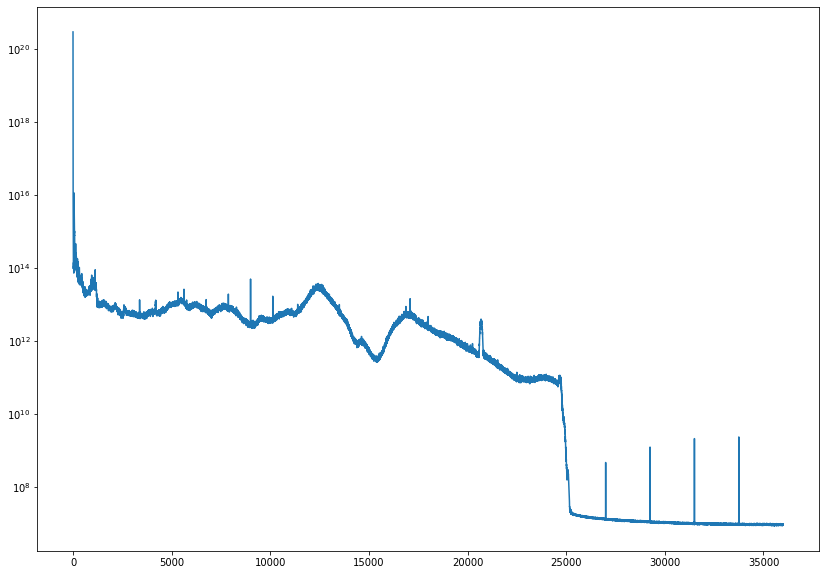

In [8]:
plt.figure(figsize=(14,10))
plt.semilogy(total_spec[:Ntby2:100])

In [15]:
import const
import mp3_util

Let's try that out:
Dates: (2015, 2, 8, 14)  animal + beep

In [70]:
mp3_arr = mp3_util.load_mp3_arr_from_datetime(datetime(2015,7,8,14))

In [71]:
mp3_filt, fw, fw_filt = mp3_util.remove_noise_wiener(mp3_arr,total_spec)

/home/jonathan/Data-Science/PDSG_DataScience/PDSG_ocean_acoustics/mp3_util.py:79: RuntimeWarning: overflow encountered in exp
  rv = 1.0 / (1.0 + np.exp((w-w0)/n) + 1E-6)


[1, 50000, 1e-06, 10000000000]

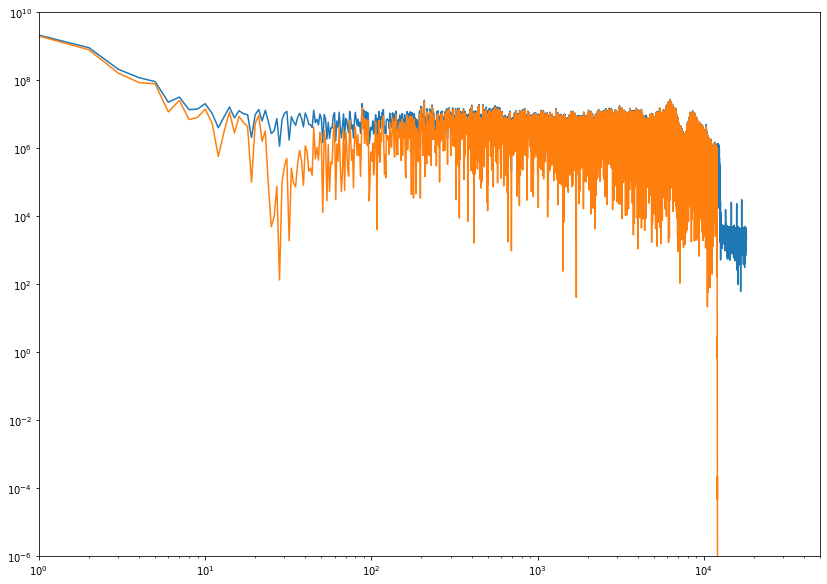

In [72]:
plt.figure(figsize=(14,10))
plt.loglog(fw[:Ntby2:200])
plt.loglog(fw_filt[:Ntby2:200])
plt.axis([1, 50000, 10**(-6), 10**10])

- Uh-oh. amplified all of the noise up as if it was signal.  Should really use 

[0, 72000.0, -100, 100]

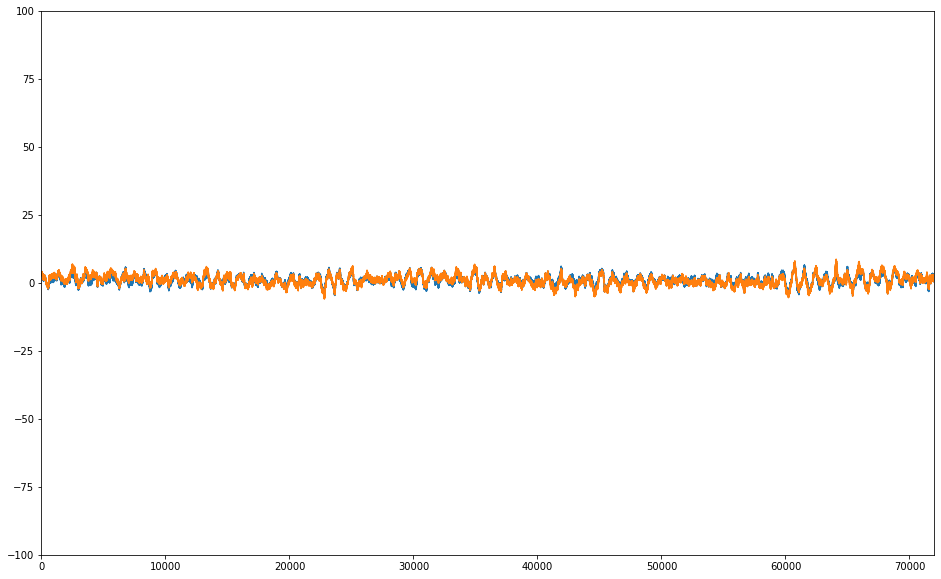

In [69]:
plt.figure(figsize=(16,10))
plt.plot(mp3_filt[::100]/np.mean(mp3_filt))
plt.plot(mp3_arr[::100]/np.mean(mp3_arr))
plt.axis([0, len(mp3_filt)/100, -100, 100])

In [39]:
from scipy.io import wavfile

In [29]:
mp3_arr=np.array(mp3_arr)

In [40]:
mp3_arr[:100]

array('h', [207, 270, 280, 288, 296, 298, 296, 276, 250, 249, 255, 256, 271, 287, 280, 269, 284, 302, 307, 302, 286, 267, 260, 264, 260, 255, 270, 292, 301, 298, 286, 270, 270, 286, 287, 281, 285, 285, 273, 272, 277, 279, 285, 300, 310, 312, 311, 308, 306, 304, 303, 304, 305, 303, 300, 292, 290, 298, 298, 293, 302, 313, 307, 295, 282, 280, 299, 323, 326, 318, 310, 298, 290, 283, 269, 260, 267, 276, 285, 288, 278, 268, 267, 258, 248, 258, 267, 254, 244, 251, 252, 231, 213, 225, 252, 249, 220, 212, 240, 273])

In [31]:
wavfile.write('og.wav', 24000, mp3_arr)
wavfile.write('filt.wav', 24000, mp3_filt)

In [43]:
len(mp3_arr)

7200000

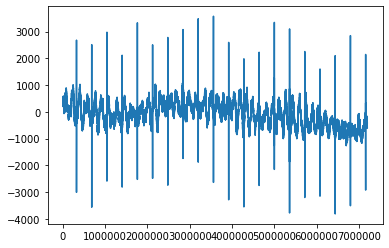

In [42]:
plt.plot(mp3_arr)


So, looks like the rough filtering algorithm just detects the weird chirping in the data.

There's a regular beeping (an artifact of the data cleaning?).  Lead to dirac comb like structure?

In [43]:
from scipy.signal import stft

In [44]:
def get_spectrogram(mp3_arr, fs=24000, nperseg=4096):

    f, t, Zft = stft(mp3_arr, fs=fs, nperseg=nperseg)
    Zft = Zft[::-1, :]  # reverse freq axis for log
    fig, ax = plt.subplots(figsize=(15,10))
    plt.imshow(np.log10(np.abs(Zft)+1), extent=[0,max(t),f[1],f[-1]], aspect='auto')
    ax.set_yscale('log')
    plt.show()

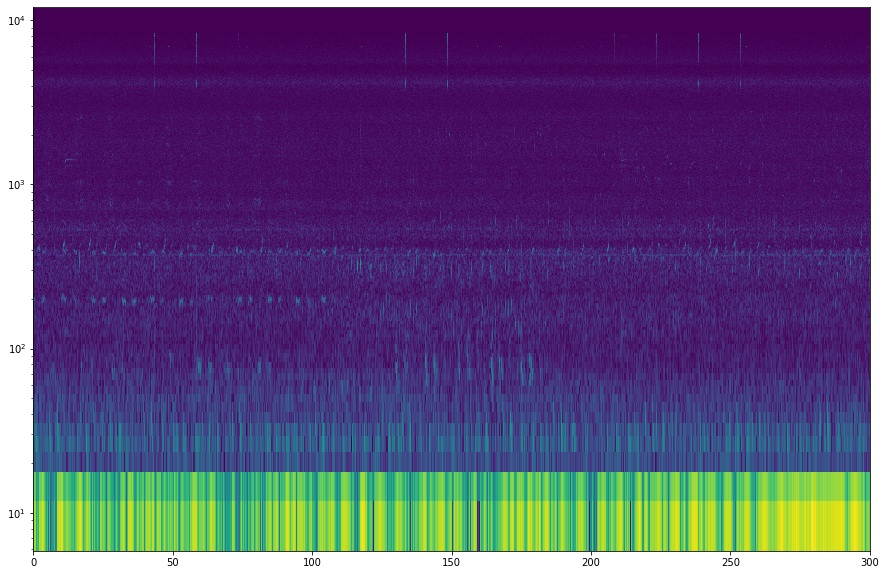

In [46]:
get_spectrogram(mp3_arr, nperseg=4096)

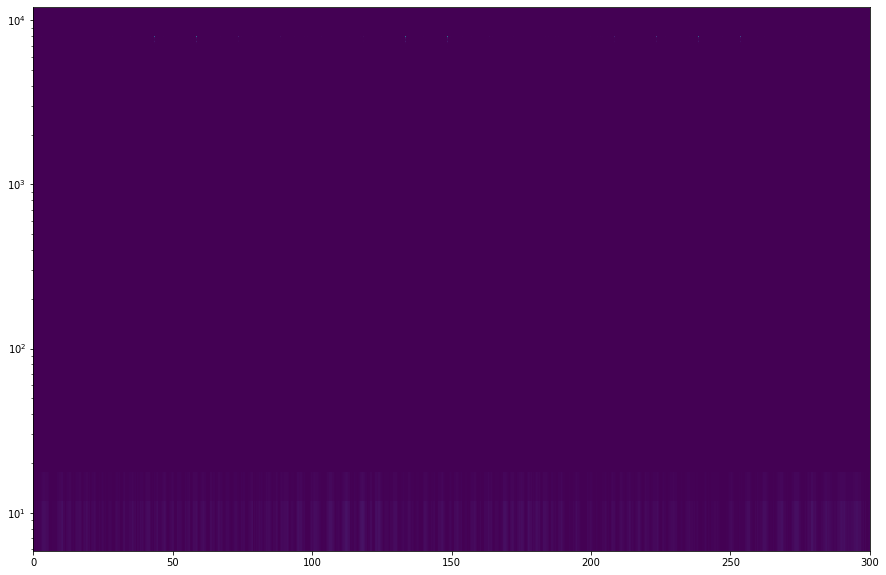

In [47]:
get_spectrogram(mp3_filt, nperseg=4096)

Could this be useful?  Maybe if we found a way to base the noise.  